# Correlation moderator simulation

In [1]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

### Naive case

Ignore positive feedback

In [159]:
N=500000

In [160]:
def convert_params(mu, theta):
    """
    Convert mean/dispersion parameterization of a negative binomial to the ones scipy supports

    See https://en.wikipedia.org/wiki/Negative_binomial_distribution#Alternative_formulations
    """
    r = theta
    var = mu + 1 / r * mu ** 2
    p = (var - mu) / var
    return r, 1 - p

In [193]:
np.var(tf1)

10.988070516283996

In [194]:
np.var(tf2)

60.021420252399984

In [205]:
tf1 = stats.nbinom.rvs(*convert_params(1, 0.1), size=N)+1
isg1 = stats.nbinom.rvs(*convert_params(0.1*tf1, 0.1))

tf2 = stats.nbinom.rvs(*convert_params(10, 2), size=N)+1
isg2 = stats.nbinom.rvs(*convert_params(10*tf2, 0.1))

In [206]:
print(stats.linregress(tf1, isg1))
print(stats.linregress(tf2, isg2))
print(stats.pearsonr(tf1, isg1))
print(stats.pearsonr(tf2, isg2))

LinregressResult(slope=0.09832758250862332, intercept=0.0013167905984799166, rvalue=0.2405618067281268, pvalue=0.0, stderr=0.0005610737773820201, intercept_stderr=0.002163625763213758)
LinregressResult(slope=10.087633171044434, intercept=-0.6746753957580864, rvalue=0.1784884169164083, pvalue=0.0, stderr=0.07864382255792923, intercept_stderr=1.0605525921783383)
(0.24056180672812283, 0.0)
(0.17848841691640852, 0.0)


### Interaction

In [148]:
tf1 = stats.nbinom.rvs(*convert_params(10, 2), size=N)
tf2 = stats.nbinom.rvs(*convert_params(10, 1), size=N)


In [149]:
isg = stats.poisson.rvs(mu=tf1*tf2)

print(stats.pearsonr(tf1, isg))
print(stats.pearsonr(tf2, isg))

(0.5071824092006413, 1.782434848128476e-66)
(0.6787801144783623, 5.4494596738883914e-136)


In [152]:
# break tf1
tf1 = stats.nbinom.rvs(*convert_params(3, 2), size=N)

isg = stats.poisson.rvs(mu=tf2*stats.binom.rvs(n=tf1, p=0.1))
print(stats.pearsonr(tf1, isg))
print(stats.pearsonr(tf2, isg))

(0.30099319342983016, 2.1822884579265597e-22)
(0.39147357025868335, 5.710121467865691e-38)


### Self coexpression

In [188]:
N = 10000

In [217]:
# WT
tf = stats.nbinom.rvs(*convert_params(1, 2), size=N)
isg1 = 2*tf + stats.norm.rvs(0, tf, size=N)
isg2 = 2*tf + stats.norm.rvs(0, tf, size=N)
print(stats.pearsonr(isg1, isg2))


(0.7027870786819179, 0.0)


In [218]:
# WT
tf = stats.nbinom.rvs(*convert_params(0.1, 2), size=N)
isg1 = 2*tf + stats.norm.rvs(0, tf, size=N)
isg2 = 2*tf + stats.norm.rvs(0, tf, size=N)
print(stats.pearsonr(isg1, isg2))


(0.7749163989278046, 0.0)


### Mediation

In [482]:
X = stats.bernoulli.rvs(p=0.5, size=N)
X_hidden = stats.norm.rvs(loc=5*X+2, size=N)
M = stats.norm.rvs(loc=2*X_hidden+2, size=N)
Y = 5*X_hidden + stats.norm.rvs(loc=0, scale=2, size=N) + 3

In [483]:
tau = stats.linregress(X, Y)[0]
alpha = stats.linregress(X, M)[0]
tau_prime = np.linalg.lstsq(np.vstack([X, M, np.ones(N)]).T, Y[:, None], rcond=-1)[0][0]
# tau_prime_separate = stats.linregress(M[X==1], Y[X==1])[1] - stats.linregress(M[X==0], Y[X==0])[1]
mediation_effect = tau - tau_prime
# mediation_effect_separate = tau - tau_prime_separate

In [484]:
tau_prime

array([4.99559625])

In [485]:
tau

25.655182120868673

In [486]:
mediation_effect

array([20.65958587])

### Sanity check

In [380]:
X = np.array([0, 1, 1, 1, 1, 1, 1, 1])
Y = stats.norm.rvs(loc=5*X)

X_p = np.array([0,1])
Y_p = np.array([Y[0], Y[1:].mean()])
weights = np.array([100, 100])

In [381]:
Y

array([-0.32423138,  4.97282704,  4.3362486 ,  5.28290631,  4.2231255 ,
        4.15306623,  6.3878851 ,  4.25159551])

In [382]:
from sklearn.linear_model import LinearRegression

In [383]:
stats.linregress(X,Y)

LinregressResult(slope=5.125324850193706, intercept=-0.32423138129323004, rvalue=0.9220341835595274, pvalue=0.0011166195617960753, stderr=0.8784790692590063, intercept_stderr=0.8217419246548144)

In [384]:
model = LinearRegression()
model.fit(X[:, None], Y[:, None])

LinearRegression()

In [385]:
model.coef_

array([[5.12532485]])

In [386]:
model = LinearRegression()
model.fit(X_p[:, None], Y_p[:, None], sample_weight=weights)

LinearRegression()

In [387]:
model.coef_

array([[5.12532485]])

### Misc

In [218]:
x = np.arange(500, 5000, 10)
q = 0.15
y1 = x**2*q**2
y2 = x*q*(1-q)

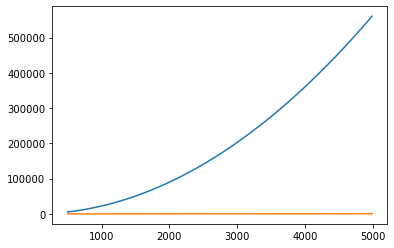

In [220]:
plt.plot(x,y1)
plt.plot(x,y2)